In [1]:

# Code for single pendulum; hard coded

# ------------------------------------------------------------------------------------------------------------------------ #

# import all necessary packages
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib 

import sys
import traceback

from scipy.integrate import solve_ivp

# ------------------------------------------------------------------------------------------------------------------------ #

# define necessary parameters; m=mass, l=length, phi=start angle, phid=start angular velocity
m_par = 0.5
l_par = 0.75
phi_par = 135
phid_par = 0

# value of g; do not change !!!
g_par = 9.81

# t_start: start simulation time; t_end: end simluation time; steps: number of steps between t_start and t_end
# time vector for simulation and animation; number of samples should not be changed to ensure real-time behaviour of animation and saved gif
# 50 fps chosen as gif could not be displayed with higher values and an increase would not be noticable for humans anyway
t_start = 0
t_end = 10
steps = (t_end-t_start)*50

# ------------------------------------------------------------------------------------------------------------------------ #

# check right format of input "parameter"; anything else than int or double raise an error message
def check_parameters(parameter):
    format = str(type(parameter)).split("'")[1]
    variable_name = [name for name, value in globals().items() if value is parameter][0]
    
    if isinstance(parameter, (int, float)) == True:
        print("Parameter", variable_name, "=", parameter, "is in the right format of", format)
    else:
        #print("Parameter", variable_name, "=", parameter, "is in the wrong format of", format)
        msg="Parameter "+variable_name+" = "+parameter+" is in the wrong format of "+format
        sys.exit(msg)

# conversion of one variable from degree to rad; input is int or double
def deg_to_rad(phi):
    variable_name = [name for name, value in globals().items() if value is phi][0]
    phi_rad = phi*(np.pi/180)
    print("Parameter", variable_name, "=", phi, "in degrees was transformed to", phi_rad, "in rad")
    return phi_rad

# This function calculates the time derivative z_dot from the state z
# the 1st argument (the time t) is not needed here
def rhs(t, z):
    phi, phid = z
    phidd = phidd_fnc(phi, phid)

    # Return the derivative of the state vector
    z_dot = np.r_[phid, phidd]
    return z_dot
    
# ------------------------------------------------------------------------------------------------------------------------ #

# check right input format of parameters
check_parameters(m_par)
check_parameters(l_par)
check_parameters(phi_par)
print("")

# do necessary precalculations from degree to rad
phi_par = deg_to_rad(phi_par)
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# create symbolic parameters
params = sp.symbols("m, l, g") 
m, l, g= params

# create smybolic time and phit
t = sp.Symbol("t")  
phit = sp.Function("phi")(t)

# construct time derivatives
phidt = phit.diff(t)
phiddt = phit.diff(t, 2)

# ------------------------------------------------------------------------------------------------------------------------ #

# kinetic energy; hard coded for one pendulum
T = 0.5*m*l**2*phidt**2
print("Kinetic energy T is:", T)
print("")

# potential energy; hard coded for one pendulum; zero at lowest point
U = m*g*l*(1-sp.cos(phit))
print("Potential energy U is:", U)
print("")

# Lagrangian
L = T - U 

# removes unnecessary factors and digits (in this case factors of 1.0)
L = sp.nsimplify(L)
T = sp.nsimplify(T)
U = sp.nsimplify(U)

# create latex expression of L, T and U
L_latex = sp.latex(L)
T_latex = sp.latex(T)
U_latex = sp.latex(U)

# check intermediate results
print("Lagrangian is:", L)
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# perform simplifications of expression L
L = L.expand()
L = sp.trigsimp(L)

# auxiliary expressions for Lagrange Equation
L_d_phi = L.diff(phit)
L_d_phid = L.diff(phidt)
DL_d_phid = L_d_phid.diff(t)

# right hand side of the equations of motion (left hand side is zero)
Eq =  DL_d_phid - L_d_phi

# create latex expression of Eq
Eq_latex = sp.latex(Eq)

# check intermediate results
print("Lagrange equation is:", Eq)
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# list of accelerations
acc = phiddt

# solve equations for acceleration symbols
res = sp.solve(Eq, acc)

print("The variable `res` (equation solved for accelerations) has the following value:", res)
print("")

# symbolic expression for acceleration
phidd_expr = res[0]

# ------------------------------------------------------------------------------------------------------------------------ #

# create symbols (so far we had functions depending on t):
phi, phid, phidd = sp.symbols("phi, phid, phidd")

# list for replacements; in each case a 2-tuple: (t-dependent function, symbol)
# note: Substitute highest time derivatives first (accelerations)
rplmts = [(phiddt, phidd), (phidt, phid), (phit, phi)]

# replace parameter symbols with start values
params_values = [(m, m_par), (l, l_par), (g, g_par)]

# perform subsitution and save result in variables
phidd_expr_num = phidd_expr.subs(rplmts+params_values)

# generation of the Python functions using sp.lambdify
phidd_fnc = sp.lambdify([phi, phid], phidd_expr_num, modules="numpy")

# ------------------------------------------------------------------------------------------------------------------------ #

# time vector for numeric simulation
tt = np.linspace(t_start, t_end, steps)

# start conditions for angle and angular velocity
zz0 = np.array([phi_par, phid_par])

# do the numerical integration
res = solve_ivp(rhs, (tt[0], tt[-1]), zz0, t_eval=tt, rtol=1e-5)

print("Numerical integration was sucessful")
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# Unpacking of individual state components.
# Arrays are always unpacked along the 1st axis (rows).
phi, phid = res.y

# kinetic energy with solved variables for visualization
T_sol = 0.5*m_par*l_par**2*phid**2
# potential energy with solved variables for visualization
U_sol = m_par*g_par*l_par*(1-np.cos(phi))

# conversion of angle and angular velocity from rad or rad/s to degree or degree/s
phi_deg=phi/(np.pi/180)
phid_deg=phid/(np.pi/180)

print("Conversion of variables sucessful")
print("")

# calculate x and y from solved angle
x = np.sin(phi)*l_par
y = -l_par*np.cos(phi)

# ------------------------------------------------------------------------------------------------------------------------ #

# txt file is created here if not already existing; otherwise just open the file
f = open("Langrangian_and_Lagrange_Equation_(Simple_Pendulum).txt", "w")

# write Lagrangian in tex notation with text
f.write("Lagrangian is:\n")
f.write(L_latex)

# spacing
f.write("\n")
f.write("\n")

# write Lagrange Equation in tex notation with text
f.write("Lagrange Equation is:\n")
f.write(Eq_latex)

# spacing
f.write("\n")
f.write("\n")

# write potential Energy U in tex notation with text
f.write("Potential Energy U is:\n")
f.write(U_latex)

# spacing
f.write("\n")
f.write("\n")

# write kinetic Energy T in tex notation with text
f.write("Kinetic Energy L is:\n")
f.write(T_latex)

# close file again
f.close()


Parameter m_par = 0.5 is in the right format of float
Parameter l_par = 0.75 is in the right format of float
Parameter phi_par = 135 is in the right format of int

Parameter phi_par = 135 in degrees was transformed to 2.356194490192345 in rad

Kinetic energy T is: 0.5*l**2*m*Derivative(phi(t), t)**2

Potential energy U is: g*l*m*(1 - cos(phi(t)))

Lagrangian is: -g*l*m*(1 - cos(phi(t))) + l**2*m*Derivative(phi(t), t)**2/2

Lagrange equation is: g*l*m*sin(phi(t)) + l**2*m*Derivative(phi(t), (t, 2))

The variable `res` (equation solved for accelerations) has the following value: [-g*sin(phi(t))/l]

Numerical integration was sucessful

Conversion of variables sucessful



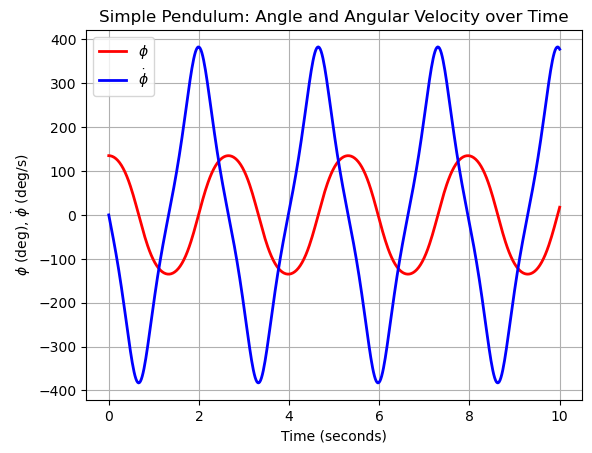

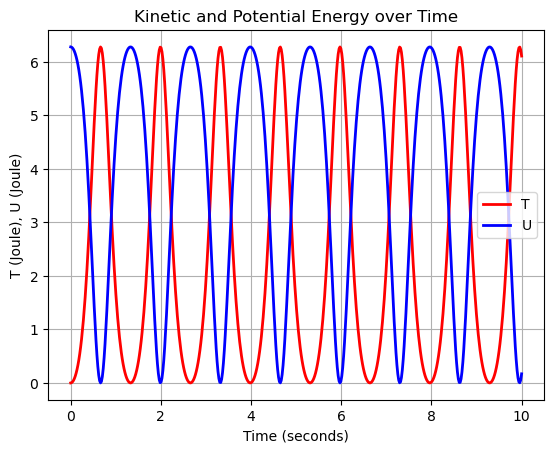

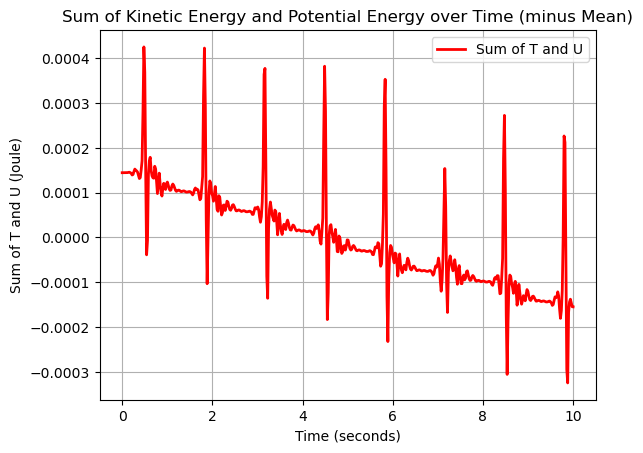


Mean of sum of T and U is: 6.279874438205378
Deviation is a maximum of 0.006776027818524808 percent in positive direction
Deviation is a maximum of 0.005171539859712201 percent in negative direction



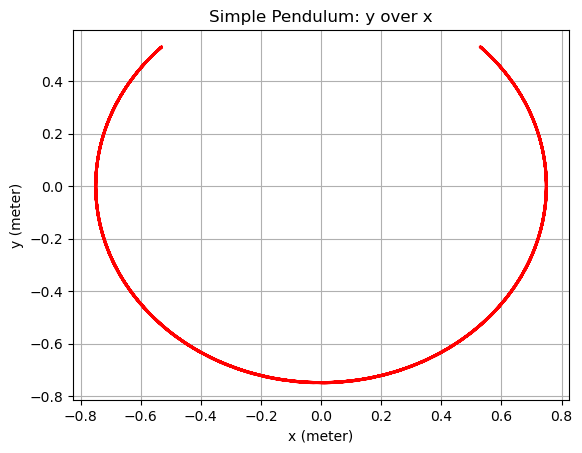

In [2]:

# plot of angle and angular velocity over time
plt.figure(1)
plt.plot(tt, phi_deg, 'r', lw=2, label=r'$\phi$')
plt.plot(tt, phid_deg, 'b', lw=2, label=r'$\dot \phi$')
plt.title('Simple Pendulum: Angle and Angular Velocity over Time')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$\phi$ (deg), $\dot \phi$ (deg/s)')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# plot of kinetic energy T and potential energy U over time
plt.figure(2)
plt.plot(tt, T_sol, 'r', lw=2, label='T')
plt.plot(tt, U_sol, 'b', lw=2, label='U')
plt.title('Kinetic and Potential Energy over Time')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'T (Joule), U (Joule)')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# calculate mean from sum of T and U -> controll if numerical simulation was sucessful (great shifts would be a hint for bad simulation results)
# mean substracted in following plot to visualize only the deviation from zero -> ideally should be zero but small deviations are okay
mean_T_plus_U = np.mean(T_sol+U_sol)

# plot of deviation of sum of T and U over time
plt.figure(3)
plt.plot(tt, T_sol + U_sol - mean_T_plus_U, 'r', lw=2, label='Sum of T and U')
plt.title('Sum of Kinetic Energy and Potential Energy over Time (minus Mean)')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Sum of T and U (Joule)')
plt.grid()
plt.show()

# ------------------------------------------------------------------------------------------------------------------------ #

# determine maximum positive and negative deviation; return both values as a positive percent value
max_error = (abs(max(T_sol + U_sol - mean_T_plus_U))/mean_T_plus_U)*100
min_error = (abs(min(T_sol + U_sol - mean_T_plus_U))/mean_T_plus_U)*100

print("")
print("Mean of sum of T and U is:", mean_T_plus_U)
print("Deviation is a maximum of", max_error, "percent in positive direction")
print("Deviation is a maximum of", min_error, "percent in negative direction")
print("")

# ------------------------------------------------------------------------------------------------------------------------ #

# plot y over x values
plt.figure(4)
plt.plot(x, y, 'r', lw=2)
plt.title('Simple Pendulum: y over x')
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.grid()
plt.show()


In [3]:

# animation of angle and angular velocity over time; angle and angular velocity are drawn in "real-time"

# ------------------------------------------------------------------------------------------------------------------------ #

# import necessary packages
from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

# define animate function; in each iteration i one pair of data is appended and displayed over again in each step
def animate(i):
    phi_curve.set_data(tt[:i+1], phi_deg[:i+1])
    phid_curve.set_data(tt[:i+1], phid_deg[:i+1])
    
# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

fig, ax = plt.subplots()

#initialize the curves with first values
phi_curve, = ax.plot(tt[0], phi_deg[0], 'r')
phid_curve, = ax.plot(tt[0], phid_deg[0], 'b')

# determine absolute maximum value for scaling of plot
max_1 = max(phi_deg)
max_2 = max(phid_deg)
min_1 = abs(min(phi_deg))
min_2 = abs(min(phid_deg))

max_all = max(max_1, max_2, min_1, min_2)

# define properties of ax from animation
ax.set_title('Simple Pendulum: Angle and Angular Velocity over Time')
ax.set_xlim(tt[0], tt[-1])
ax.set_ylim(-max_all, max_all)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r'$\phi$ (deg), $\dot \phi$ (deg/s)')
ax.legend([r'$\phi$', r'$\dot \phi$'])
ax.grid(1)

# ------------------------------------------------------------------------------------------------------------------------ #

# cretae animation within fig with function animate and some parameters
# interval approximated so that animation takes roughly the same time as simulated for a real time effect
ani = animation.FuncAnimation(fig, animate, frames=len(tt), interval=1000 * tt.max() / len(tt))

# prevents additional static plot that is not used
plt.close()

# open animation with this line
HTML(ani.to_jshtml())

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
ani.save("Single_Pendulum_angle_and_angular_velocity.gif", dpi=300, writer=PillowWriter(fps=50))


In [4]:

# animation of pendulum motion over time; motion is drawn in "real-time"

# ------------------------------------------------------------------------------------------------------------------------ #

# import necessary packages
from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

# calculate pendulum position in x and y coordinates from angle and length of pendulum
def pend_pos(phi):
    return (l_par*np.sin(phi), -l_par*np.cos(phi))

# define animate function; in each iteration i one pair of data is appended and displayed over again in each step
def animate(i):
    x,y = pend_pos(phi[i])
    line.set_data([0, x], [0, y])
    circle.set_center((x, y))
    
# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

# create figure
fig = plt.figure()

# define properties of ax from animation
ax = fig.add_subplot(aspect='equal')
ax.set_xlim(-1.1*l_par, 1.1*l_par)
ax.set_ylim(-1.1*l_par, 1.1*l_par)
ax.set_title('Simple Pendulum: Pendel Motion over Time')
ax.set_xlabel('x in m')
ax.set_ylabel('y in m')
ax.grid(1)

# determine start values for x and y and thus the line and circle
x0, y0 = pend_pos(phi_par)
line, = ax.plot([0, x0], [0, y0], lw=2, c='k')
circle = ax.add_patch(plt.Circle(pend_pos(phi_par), m_par*0.05, fc='r', zorder=3))

# ------------------------------------------------------------------------------------------------------------------------ #

# cretae animation within fig with function animate and some parameters
# interval approximated so that animation takes roughly the same time as simulated for a real time effect
ani = animation.FuncAnimation(fig, animate, frames=len(tt), interval=1000 * tt.max() / len(tt))

# prevents additional static plot that is not used
plt.close()

# open animation with this line
HTML(ani.to_jshtml())

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
ani.save("Single_Pendulum_motion.gif", dpi=300, writer=PillowWriter(fps=50))
